In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
with open("poisson.pkl", "rb") as f:
    (fs, us) = pickle.load(f)

In [3]:
prop_train = 0.75
N = fs.shape[0]
N_train = int(N * prop_train)

f_cal = torch.from_numpy(fs[N_train:]).to(torch.float32).to("cuda")
u_cal = us[N_train:]

In [4]:
class SpecOp(nn.Module):
    def __init__(self, k_in, k_out):
        super().__init__()

        hidden_features = 16
        self.linear1 = nn.Linear(k_in, hidden_features)
        self.linear2 = nn.Linear(hidden_features, hidden_features)
        self.linear3 = nn.Linear(hidden_features, k_out)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x
    
with open("poisson.pkl", "rb") as f:
    (fs, us) = pickle.load(f)

net  = SpecOp(fs.shape[-1], us.shape[-1])

In [5]:
net.load_state_dict(torch.load("poisson.pt", weights_only=True))
net.eval().to("cuda")

SpecOp(
  (linear1): Linear(in_features=65536, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=65536, bias=True)
)

In [6]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)


In [50]:
u_hat = net(f_cal).cpu().detach().numpy()
u_hat = np.transpose(u_hat.reshape((u_hat.shape[0], 256, 256)), (0, 2, 1))
u_cal = np.transpose(u_cal.reshape((u_hat.shape[0], 256, 256)), (0, 2, 1))

In [59]:
s = 2 # working w/ Laplacian in PDE immediately imposes s = 2 smoothness
    
def sobolev_cp_cov(K, gamma, cal_size=100, alpha=0.05):
    coords = cartesian_product(
        np.array(range(u_hat.shape[-2])), 
        np.array(range(u_hat.shape[-1]))
    ).reshape((u_hat.shape[-2], u_hat.shape[-1], 2))
    ks = np.sum(coords, axis=-1)
    d = len(u_hat[0].shape)
    
    sobolev_scaling = (1 + ks ** (2 * d)) ** (s - gamma)
    
    full_sobolev_residual = (sobolev_scaling * (u_hat - u_cal))[:150,:150]
    full_sobolev_norm = full_sobolev_residual.reshape(-1, np.prod(full_sobolev_residual.shape[1:])).sum(axis=-1)
    
    truncated_sobolev_residual = full_sobolev_residual[:K, :K]
    truncated_sobolev_norm = truncated_sobolev_residual.reshape(-1, K * K).sum(axis=-1)

    cal_norms, truncated_test_norms = truncated_sobolev_norm[:cal_size], truncated_sobolev_norm[cal_size:]
    q_hat = np.quantile(cal_norms, 1-alpha)

    # NOTE: this coverage is the standard CP guarantee -- we only use for debugging
    # coverage = np.sum(truncated_test_norms < q_hat) / len(truncated_test_norms)
    # print(f"[DEBUG] Coverage: {coverage} vs {1 - alpha}")
    
    full_coverage = np.sum(full_sobolev_norm < q_hat) / len(truncated_test_norms)
    return full_coverage

In [60]:
gamma_to_cov = {}
for gamma in range(0, s):
    Ks = np.arange(10, 101, 10)
    coverages = []
    for K in Ks:
        coverage = sobolev_cp_cov(K, gamma)
        coverages.append(coverage)
    gamma_to_cov[gamma] = np.array(coverages)

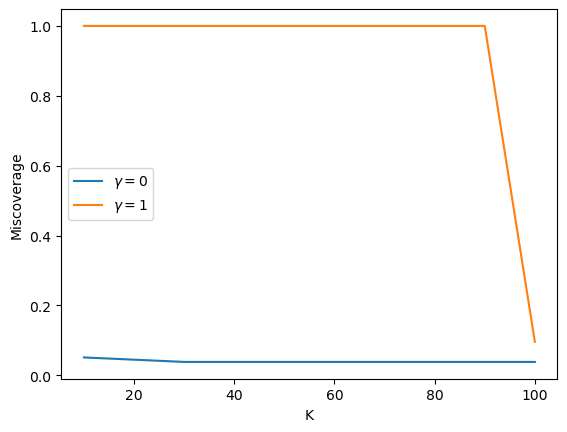

In [65]:
plt.xlabel("K")
plt.ylabel("Miscoverage")

for gamma in gamma_to_cov:
    plt.plot(Ks, 1 - gamma_to_cov[gamma], label=r"$\gamma = " + str(gamma) + "$")
plt.legend()